<a href="https://colab.research.google.com/github/GeorglChen/Simulating-The-Dynamics-of-a-Ballistic-Missile/blob/main/Simulating_The_Dynamics_of_a_Ballistic_Missile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import scipy as sp
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

#Simulating
We can compute the robotic system matrices using the formula

$$ \begin{bmatrix} \mathbf{A}_{\textsf{d}} & \mathbf{B}_{\textsf{d}} \\ \mathbf{0} & \mathbf{I}\end{bmatrix} = \textrm{exp}\left(\begin{bmatrix} \mathbf{A} & \mathbf{B} \\ \mathbf{0} & \mathbf{0}\end{bmatrix}T\right)$$

In [ ]:
def computing_the_system_matrices(A,B,C,D,T):
  #computing the matrix
  M = np.concatenate((A,B),axis = 1)
  l = max(M.shape[0], M.shape[1])
  M.resize(l,l)

  #computing the matrix exponential
  M_exp = sp.linalg.expm(M*T)

  #Get A_d and B_d
  A_d = M_exp[0:A.shape[0],0:A.shape[1]]
  B_d = M_exp[0:A.shape[0],A.shape[1]:]

  return A_d, B_d, C, D


Now to simulate the robotic system with time

In [ ]:
def simulate_the_system(x_0, u_0, A, B, C, D, sim_time, T, func):
    steps = int(sim_time / T)
    state = [x_0]
    u = u_0

    for _ in range(steps):
        x = np.matmul(A, state[-1]) + np.matmul(B, u)
        state.append(x)
        y = np.matmul(C, x) + np.matmul(D, u)
        u = func(y)
        # Terminate if the missile hits the ground (y <= 0)
        if x[2, 0] <= 0:  # y position is the third state variable (index 2)
            break

    state = np.array(state)[:, :, 0]  # Convert list to array and remove singleton dimension
    time = np.linspace(0, sim_time, len(state[:, 0]))
    position_x = state[:, 0]
    position_y = state[:, 2]  # y position

    return time, position_x, position_y

We now will set up the problem

In [ ]:
m = 1000 # mass of the missle
T = 0.01 # sampling period
g = 9.81 # acceleration due to gravity
c = 1000 # drag coefficient y
d = 1000 # drag coefficient x

def func(y):
  return np.array([[0],[-m*g]])

Defining the matrix of the system

$$
\mathbf{A} = \begin{bmatrix}
0 & 1 & 0 & 0 \\
0 & -\frac{d}{m} & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 0 & -\frac{c}{m}
\end{bmatrix}, \quad
\mathbf{B} = \begin{bmatrix}
0 & 0 \\
\frac{1}{m} & 0 \\
0 & 0 \\
0 & \frac{1}{m}
\end{bmatrix}, \quad
\mathbf{C} = \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & 1 & 0
\end{bmatrix}, \quad
\mathbf{D} = \begin{bmatrix}
0 & 0 \\
0 & 0
\end{bmatrix}
 $$

In [ ]:
# Define the system (2D motion: x and y directions)
A = np.array([[0, 1, 0, 0],  # x position and velocity
              [0, -d/m, 0, 0],  # velocity dynamics (x)
              [0, 0, 0, 1],  # y position and velocity
              [0, 0, 0, -c/m]])  # velocity dynamics (y)

B = np.array([[0,0],
              [1/m,0],
              [0,0],
              [0,1/m]])  # No input to position/velocity, modify if needed

C = np.array([[1, 0, 0, 0],
              [0, 0, 1, 0]])  # Measure x and y position

D = np.array([[0,0],
              [0,0]])

Now computing the robotic system

In [ ]:
A_d, B_d, C_d, D_d = computing_the_system_matrices(A,B,C,D,T)

Defining the initial conditions

In [ ]:
# Initial conditions (position and velocity in both x and y directions)
d_0 = 0  # initial x position
d_dot0 = 200  # initial x velocity
y_0 = 0  # initial y position
y_dot0 = 20  # initial y velocity

x_0 = np.array([[d_0], [d_dot0], [y_0], [y_dot0]])
u_0 = np.array([[0],[-m*g]])

Running the simulation

In [ ]:
time, position_x, position_y = simulate_the_system(x_0, u_0, A_d, B_d, C_d, D_d, 10, T, func=func)

Now visualizing the animation

In [ ]:
# Initialize the plot elements
def init():
    line.set_data([], [])         # Current position
    trajectory.set_data([], [])  # Trajectory
    ground.set_data([], []) # Reference line
    return line, trajectory, ground

# Update function to move the missile and plot the trajectory
def update(frame):
    pos_x = position_x[:frame + 1]  # All x positions up to the current frame
    pos_y = position_y[:frame + 1]  # All y positions up to the current frame

    # Set missile's current position
    line.set_data(position_x[frame], position_y[frame])

    # Set trajectory line
    trajectory.set_data(pos_x, pos_y)

    # Optionally update the center line
    X_old = [-10000, 10000]
    Y_old = [0, 0]

    X_new = np.linspace(-100, 2000, 500)
    f = interp1d(X_old, Y_old)
    Y_new = f(X_new)
    ground.set_data(X_new, Y_new)

    # Dynamically adjust the axis if needed
    ax.set_xlim(min(pos_x) - 50, max(pos_x) + 50)
    ax.set_ylim(min(pos_y) - 10, max(pos_y) + 10)

    return line, trajectory, ground

<ipython-input-109-5edaad639f16>:14: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_data(position_x[frame], position_y[frame])


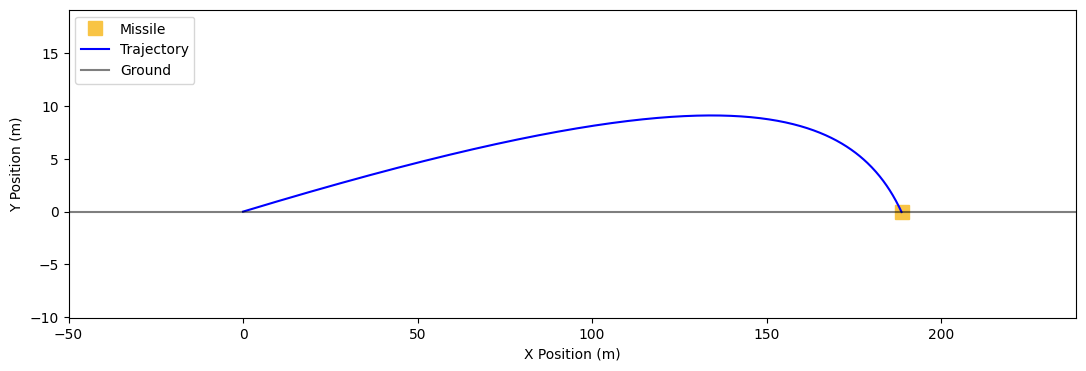

In [ ]:
# Set up the figure and axis for 2D motion
fig, ax = plt.subplots(figsize=(13, 4))
ax.set_xlim(-50, 50)
ax.set_ylim(-50, 50)

# Create empty lines for missile position
line, = ax.plot([], [], 's', color='#f8c445', label='Missile', markersize=10)
# Add trajectory line
trajectory, = ax.plot([], [], '-', color='blue', label='Trajectory')
# Create center line (you can keep this part or remove it depending on your use case)
ground, = ax.plot([], [], 'k', label='Ground', alpha=0.5)

ax.set_xlabel("X Position (m)")
ax.set_ylabel("Y Position (m)")
ax.legend(loc='upper left')

# Create animation
ani = FuncAnimation(fig, update, frames=len(time), init_func=init, blit=True, interval=int(T*1000))
HTML(ani.to_html5_video())

# Optimization
Now we want to introduce the optimization problem by setting a target of the missile and optimizing the time it takes for the missle to hit its target

Thus we can introduce the optimization problem as

$$
\text{minimize} \quad \sum_{k=1}^{N} \| v_{k+1} - v_k \|^2
$$
Subject to:
$$
    \dot{\mathbf{v}}(t)=\mathbf{A}\mathbf{v}(t)+\mathbf{B}\mathbf{u}(t), \ \ \text{for} \ \ t\in [0,T]
$$

$$
y \ge 0
$$

$$
    \mathbf{v}(0)=(x_0,\dot{x}_0,y_0,\dot{y}_0),\ \ \mathbf{v}(T) =(x_\text{target},\dot{x}_\text{target},y_\text{target},\dot{y}_\text{target})
$$


To start let's set the initial variables again so that the code a more modular.

In [ ]:
#Setting the inital variables again
m = 1000 # mass of the missle
T = 0.1 # sampling period
g = 9.81 # acceleration due to gravity
c = 1000 # drag coefficient y
d = 1000 # drag coefficient x

# Define the system (2D motion: x and y directions)
A = np.array([[0, 1, 0, 0],  # x position and velocity
              [0, -d/m, 0, 0],  # velocity dynamics (x)
              [0, 0, 0, 1],  # y position and velocity
              [0, 0, 0, -c/m]])  # velocity dynamics (y)

B = np.array([[0,0],
              [1/m,0],
              [0,0],
              [0,1/m]])  # No input to position/velocity, modify if needed

C = np.array([[1, 0, 0, 0],
              [0, 0, 1, 0]])  # Measure x and y position

D = np.array([[0,0],
              [0,0]])

#Computing robotic system
A_d, B_d, C_d, D_d = computing_the_system_matrices(A,B,C,D,T)

#Inital and final motion
x_0 = np.array([[0], [-100], [0], [200]]) # d_0, d_dot0, y_0, y_dot0
x_target = np.array([[1000], [10], [0], [-10]]) # x_target, x_dot_target, y_target, y_dot_target
u_0 = np.array([[0],[-m*g]])

Now that the intial conditions are set we can define the optimization problem.

In [ ]:
import cvxpy as cp
N = 50

# CVXPY optimization setup
# Define variables
v = cp.Variable((N+1, 4))  # State trajectory (N+1 because we include v(0) and v(T))
u = cp.Variable((N, 2))    # Control input trajectory (N time steps)

# Define constraints
constraints = []

# Initial condition
constraints.append(v[0] == x_0.flatten())

# System dynamics constraints
for k in range(N):
    constraints.append(v[k+1] == A_d @ v[k] + B_d @ u[k])

for k in range(N+1):  # Include all states from v[0] to v[N]
    constraints.append(v[k][2] >= 0)  # Ensure y-coordinate is non-negative

# Terminal state constraint: Ensure v(T) equals the target state
constraints.append(v[N] == x_target.flatten())  # Force final state to match target

objective = cp.Minimize(cp.sum_squares(v[1:] - v[:-1]))

# Solve the problem
problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.CLARABEL, verbose=True)

# Check if the optimization was successful
if problem.status != cp.OPTIMAL:
    print("Optimization failed. Status:", problem.status)
else:
    # Extract optimal controls and states
    v_opt = v.value
    u_opt = u.value

    # Format control inputs for simulation
    U = []
    for k in range(N):
        u_k = u_opt[k]
        U.append([[u_k[0]], [u_k[1]]])

                                     CVXPY                                     
                                     v1.5.4                                    
(CVXPY) Dec 04 08:42:17 PM: Your problem has 304 variables, 259 constraints, and 0 parameters.
(CVXPY) Dec 04 08:42:17 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 04 08:42:17 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 04 08:42:17 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Dec 04 08:42:17 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 04 08:42:17 PM: Compiling problem (target solver=CLARABEL

<ipython-input-109-5edaad639f16>:14: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_data(position_x[frame], position_y[frame])


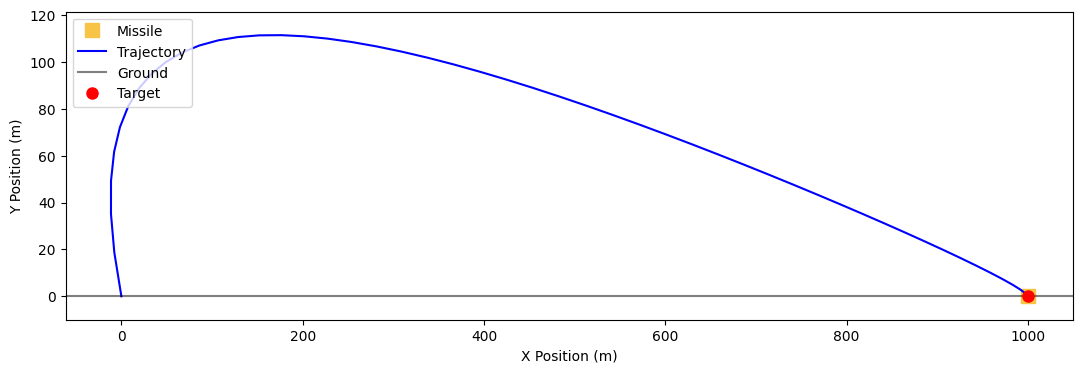

In [ ]:
def simulate_with_controls(x_0, U, A, B, C, D, sim_time, T):

    steps = int(sim_time / T)
    state = [x_0]

    # Simulate using precomputed control inputs
    for i in range(steps):
        # Use the ith control input or the last one if i >= len(U)
        u = U[i] if i < len(U) else [[0],[0]]

        # State update
        x = np.matmul(A, state[-1]) + np.matmul(B, u)

        state.append(x)

        y = np.matmul(C, x) + np.matmul(D, u)

        # Terminate if missile hits the ground (y <= 0)
        if x[2, 0] <= 0:
            break
    state = np.array(state)[:, :, 0]  # Convert list to array and remove singleton dimension
    time = np.linspace(0, sim_time, len(state[:, 0]))
    position_x = state[:, 0]
    position_y = state[:, 2]  # y position
    return time, position_x, position_y

T = 0.1
sim_time = 30
time, position_x, position_y = simulate_with_controls(x_0, U, A_d, B_d, C_d, D_d, sim_time, T=T)

# Set up the figure and axis for 2D motion
fig, ax = plt.subplots(figsize=(13, 4))
ax.set_xlim(-50, 50)
ax.set_ylim(-50, 50)

# Create empty lines for missile position
line, = ax.plot([], [], 's', color='#f8c445', label='Missile', markersize=10)
# Add trajectory line
trajectory, = ax.plot([], [], '-', color='blue', label='Trajectory')
# Create center line (you can keep this part or remove it depending on your use case)
ground, = ax.plot([], [], 'k', label='Ground', alpha=0.5)
# Add target point
target_point, = ax.plot(x_target[0], x_target[2], 'ro', label='Target', markersize=8)

ax.set_xlabel("X Position (m)")
ax.set_ylabel("Y Position (m)")
ax.legend(loc='upper left')

# Create animation
ani = FuncAnimation(fig, update, frames=len(time), init_func=init, blit=True, interval=int(T*1000))
HTML(ani.to_html5_video())